# DUTCH Fastshap vs FastShap with DP

In [1]:
import shap  # https://github.com/slundberg/shap
import shapreg  # https://github.com/iancovert/shapley-regression
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import os
import torch
from fastshap import FastSHAP
from scipy.stats import sem
from fastshap.utils import MaskLayer1d
import torch.nn as nn
from fastshap import Surrogate, KLDivLoss
from utils import prepare_data
from scipy.stats import spearmanr
import shap  # https://github.com/slundberg/shap
import shapreg  # https://github.com/iancovert/shapley-regression
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import os
import torch
from fastshap import FastSHAP
from scipy.stats import sem
from fastshap.utils import MaskLayer1d
import torch.nn as nn
import torch.nn.functional as F
from fastshap import Surrogate, KLDivLoss
from aix360.metrics.local_metrics import faithfulness_metric
from scipy.stats import kendalltau
import matplotlib.pyplot as plt

/home/lcorbucci/private_fast_shap/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Functions

In [2]:
# Faithfulness evaluation
class aix_model:
    def __init__(self, model):
        self.model = model

    def predict(self, x):
        x = torch.Tensor(x)
        return self.model(x).argmax(dim=1)

    def predict_proba(self, x):
        # since the activation function of the last layer is LogSoftmax
        # we need to apply the exponential to the output of the model
        # cast x to be a Tensor
        x = torch.Tensor(x)
        return torch.exp(self.model(x)).detach().numpy()


def compute_faithfulness(x, y, fastshap_explanation, model, base_value=0.2):
    x = x[0]
    fastshap_explanation = np.array(torch.tensor(fastshap_explanation).cpu())

    faithfulness = faithfulness_metric(
        model=model,
        x=np.array(x),
        coefs=fastshap_explanation,
        base=base_value * np.ones(shape=fastshap_explanation.shape[0]),
    )
    return faithfulness


def process_explainer(explanation_file_name, explainer, model, x, y, index, base_value):
    if not os.path.isfile(f"./plots_data/{explanation_file_name}_{index}.pt"):
        fastshap_explanation = explainer.shap_values(x)[0][:, y]
        torch.save(
            fastshap_explanation,
            f"./plots_data/{explanation_file_name}_{index}.pt",
        )
    else:
        fastshap_explanation = torch.load(
            f"./plots_data/{explanation_file_name}_{index}.pt"
        )

    if not os.path.isfile(
        f"./plots_data/faithfulness_{explanation_file_name}_{index}_{base_value}.pt"
    ):
        faithfulness = compute_faithfulness(
            x,
            y,
            fastshap_explanation,
            model,
            base_value=base_value,
        )
        torch.save(
            faithfulness,
            f"./plots_data/faithfulness_{explanation_file_name}_{index}_{base_value}.pt",
        )
    else:
        faithfulness = torch.load(
            f"./plots_data/faithfulness_{explanation_file_name}_{index}_{base_value}.pt"
        )
    return fastshap_explanation, faithfulness

In [3]:
class Args:
    def __init__(self):
        self.dataset_name = "adult"
        self.sweep = True


args = Args()
args.seed = 42
args.sweep = False
args.dataset_name = "dutch"
(
    train_set,
    val_set,
    test_set,
    X_train,
    X_val,
    X_test,
    Y_train,
    Y_val,
    Y_test,
    num_features,
    feature_names,
) = prepare_data(args)


class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [4]:
def plot_faithfulness_std_dev(
    faithfulness_no_dp,
    faithfulness_eps_05,
    faithfulness_eps_1,
    faithfulness_eps_2,
    faithfulness_eps_3,
    faithfulness_eps_4,
    faithfulness_eps_5,
    faithfulness_eps_10,
    faithfulness_eps_100,
):
    mean_no_dp = np.mean(faithfulness_no_dp)
    std_no_dp = np.std(faithfulness_no_dp)

    mean_eps_05 = np.mean(faithfulness_eps_05)
    std_eps_05 = np.std(faithfulness_eps_05)

    mean_eps_1 = np.mean(faithfulness_eps_1)
    std_eps_1 = np.std(faithfulness_eps_1)

    mean_eps_2 = np.mean(faithfulness_eps_2)
    std_eps_2 = np.std(faithfulness_eps_2)

    mean_eps_3 = np.mean(faithfulness_eps_3)
    std_eps_3 = np.std(faithfulness_eps_3)

    mean_eps_4 = np.mean(faithfulness_eps_4)
    std_eps_4 = np.std(faithfulness_eps_4)

    mean_eps_5 = np.mean(faithfulness_eps_5)
    std_eps_5 = np.std(faithfulness_eps_5)

    mean_eps_10 = np.mean(faithfulness_eps_10)
    std_eps_10 = np.std(faithfulness_eps_10)

    mean_eps_100 = np.mean(faithfulness_eps_100)
    std_eps_100 = np.std(faithfulness_eps_100)

    results_mean = {
        "No DP": [mean_no_dp],
        "Eps. 05": [mean_eps_05],
        "Eps. 1": [mean_eps_1],
        "Eps. 2": [mean_eps_2],
        "Eps. 3": [mean_eps_3],
        "Eps. 4": [mean_eps_4],
        "Eps. 5": [mean_eps_5],
        "Eps. 10": [mean_eps_10],
        "Eps. 100": [mean_eps_100],
    }

    results_std = {
        "No DP": [std_no_dp],
        "Eps. 05": [std_eps_05],
        "Eps. 1": [std_eps_1],
        "Eps. 2": [std_eps_2],
        "Eps. 3": [std_eps_3],
        "Eps. 4": [std_eps_4],
        "Eps. 5": [std_eps_5],
        "Eps. 10": [std_eps_10],
        "Eps. 100": [std_eps_100],
    }

    # Extracting the means and standard errors

    labels = list(results_mean.keys())
    means = [results_mean[label][0] for label in labels]
    errors = [results_std[label][0] for label in labels]

    # Plotting
    plt.figure(figsize=(8, 6))

    # Use different markers for each point
    markers = ["o", "s", "^", "D", "P", "X", "H", "v", "<", ">", "d", "p", "*", "h"]

    for i, label in enumerate(labels):
        plt.errorbar(
            i,
            means[i],
            yerr=errors[i],
            fmt=markers[i],
            label=label,
            capsize=5,
            markersize=10,
        )

    # Customizing the plot
    plt.xticks(range(len(labels)), labels, fontsize=12)
    plt.ylabel("Mean Faithfulness", fontsize=14)
    plt.title(
        "Mean Faithfulness with Standard Deviation for Different Epsilon Values",
        fontsize=16,
    )
    plt.grid(True, linestyle="--", linewidth=0.5)
    plt.legend(fontsize=12)
    plt.tight_layout()

    # orientation x axis labels
    plt.xticks(rotation=90)

    plt.show()


def plot_error_bar(labels, results_mean, results_std, y_label, title):
    means = [results_mean[label][0] for label in labels]
    errors = [results_std[label][0] for label in labels]

    # Plotting
    plt.figure(figsize=(8, 6))

    # Use different markers for each point
    markers = ["o", "s", "^", "D", "P", "X", "H", "v", "<", ">", "d", "p", "*", "h"]

    for i, label in enumerate(labels):
        plt.errorbar(
            i,
            means[i],
            yerr=errors[i],
            fmt=markers[i],
            label=label,
            capsize=5,
            markersize=10,
        )

    # Customizing the plot
    plt.xticks(range(len(labels)), labels, fontsize=12)
    plt.ylabel(y_label, fontsize=14)
    plt.title(
        title,
        fontsize=16,
    )
    plt.grid(True, linestyle="--", linewidth=0.5)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.xticks(rotation=90)

    plt.show()

### Load Data

In [5]:
# Select device
device = torch.device("cuda")
import dill

# Original model without DP
if os.path.isfile("./train_dutch/baseline_dutch_model_NO_DP.pth"):
    print("Loading saved model")
    model_no_dp = torch.load("./train_dutch/baseline_dutch_model_NO_DP.pth").to("cpu")
    model_no_dp_aix = aix_model(model_no_dp)
# Surrogate model without DP
if os.path.isfile("./train_surrogate/surrogate_Dutch_NO_DP.pt"):
    print("Loading saved surrogate model")
    surr = torch.load("./train_surrogate/surrogate_Dutch_NO_DP.pt").to(device)
    surrogate = Surrogate(surr, num_features)

# NO DP
if os.path.isfile("./train_explainer/explainer_dutch_NO_DP.pt"):
    print("Loading saved explainer model")
    explainer = torch.load("./train_explainer/explainer_dutch_NO_DP.pt").to(device)
    fastshap_NO_DP = FastSHAP(
        explainer, surrogate, normalization="additive", link=nn.Softmax(dim=-1)
    )

# DP 0.5
if os.path.isfile("./train_explainer/explainer_dutch_DP_05.pt"):
    print("Loading saved explainer model")
    explainer = torch.load("./train_explainer/explainer_dutch_DP_05.pt").to(device)
    fastshap_DP_05 = FastSHAP(
        explainer, surrogate, normalization="none", link=nn.Softmax(dim=-1)
    )

# DP 1
if os.path.isfile("./train_explainer/explainer_dutch_DP_1.pt"):
    print("Loading saved explainer model")
    explainer = torch.load("./train_explainer/explainer_dutch_DP_1.pt").to(device)
    fastshap_DP_1 = FastSHAP(
        explainer, surrogate, normalization="additive", link=nn.Softmax(dim=-1)
    )


# DP 2
if os.path.isfile("./train_explainer/explainer_dutch_DP_2.pt"):
    print("Loading saved explainer model")
    explainer = torch.load("./train_explainer/explainer_dutch_DP_2.pt").to(device)
    fastshap_DP_2 = FastSHAP(
        explainer, surrogate, normalization="multiplicative", link=nn.Softmax(dim=-1)
    )

# DP 3
if os.path.isfile("./train_explainer/explainer_dutch_DP_3.pt"):
    print("Loading saved explainer model")
    explainer = torch.load("./train_explainer/explainer_dutch_DP_3.pt").to(device)
    fastshap_DP_3 = FastSHAP(
        explainer, surrogate, normalization="additive", link=nn.Softmax(dim=-1)
    )

# DP 4
if os.path.isfile("./train_explainer/explainer_dutch_DP_4.pt"):
    print("Loading saved explainer model")
    explainer = torch.load("./train_explainer/explainer_dutch_DP_4.pt").to(device)
    fastshap_DP_4 = FastSHAP(
        explainer, surrogate, normalization="additive", link=nn.Softmax(dim=-1)
    )

# DP 5
if os.path.isfile("./train_explainer/explainer_dutch_DP_5.pt"):
    print("Loading saved explainer model")
    explainer = torch.load("./train_explainer/explainer_dutch_DP_5.pt").to(device)
    fastshap_DP_5 = FastSHAP(
        explainer, surrogate, normalization="multiplicative", link=nn.Softmax(dim=-1)
    )

# DP 10
if os.path.isfile("./train_explainer/explainer_dutch_DP_10.pt"):
    print("Loading saved explainer model")
    explainer = torch.load("./train_explainer/explainer_dutch_DP_10.pt").to(device)
    fastshap_DP_10 = FastSHAP(
        explainer, surrogate, normalization="additive", link=nn.Softmax(dim=-1)
    )

# DP 100
if os.path.isfile("./train_explainer/explainer_dutch_DP_100.pt"):
    print("Loading saved explainer model")
    explainer = torch.load("./train_explainer/explainer_dutch_DP_100.pt").to(device)
    fastshap_DP_100 = FastSHAP(
        explainer, surrogate, normalization="additive", link=nn.Softmax(dim=-1)
    )

Loading saved model
Loading saved surrogate model
Loading saved explainer model
Loading saved explainer model
Loading saved explainer model
Loading saved explainer model
Loading saved explainer model
Loading saved explainer model
Loading saved explainer model
Loading saved explainer model
Loading saved explainer model


In [6]:
model_predictions = []
for x in X_test:
    model_prediction = model_no_dp(torch.Tensor(x).unsqueeze(0)).argmax()
    model_predictions.append(model_prediction)

/home/lcorbucci/private_fast_shap/.venv/lib/python3.10/site-packages/torch/nn/modules/module.py:1373: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


In [7]:
import copy

fast_NO_DP = []
fast_05 = []
fast_1 = []
fast_2 = []
fast_3 = []
fast_4 = []
fast_5 = []
fast_10 = []
fast_100 = []

faithfulness_no_dp = []
faithfulness_eps_05 = []
faithfulness_eps_1 = []
faithfulness_eps_2 = []
faithfulness_eps_3 = []
faithfulness_eps_4 = []
faithfulness_eps_5 = []
faithfulness_eps_10 = []
faithfulness_eps_100 = []

base_value = 100

for index, (x, y) in enumerate(zip(X_test, model_predictions)):
    y = 0 if not y else 1
    x = np.array([list(x)])

    shap_NO_DP, faithfulness_NO_DP = process_explainer(
        "dutch_explainer_NO_DP_surrogate_NO_DP_model_NO_DP",
        fastshap_NO_DP,
        model_no_dp_aix,
        x,
        y,
        index,
        base_value,
    )
    fast_NO_DP.append(copy.deepcopy(shap_NO_DP))
    faithfulness_no_dp.append(faithfulness_NO_DP)

    shap_DP_05, faithfulness_DP_05 = process_explainer(
        "dutch_explainer_DP_05_surrogate_NO_DP_model_NO_DP",
        fastshap_DP_05,
        model_no_dp_aix,
        x,
        y,
        index,
        base_value,
    )
    fast_05.append(copy.deepcopy(shap_DP_05))

    faithfulness_eps_05.append(faithfulness_DP_05)

    shap_DP_1, faithfulness_DP_1 = process_explainer(
        "dutch_explainer_DP_1_surrogate_NO_DP_model_NO_DP",
        fastshap_DP_1,
        model_no_dp_aix,
        x,
        y,
        index,
        base_value,
    )
    fast_1.append(copy.deepcopy(shap_DP_1))

    faithfulness_eps_1.append(faithfulness_DP_1)

    shap_DP_2, faithfulness_DP_2 = process_explainer(
        "dutch_explainer_DP_2_surrogate_NO_DP_model_NO_DP",
        fastshap_DP_2,
        model_no_dp_aix,
        x,
        y,
        index,
        base_value,
    )

    fast_2.append(copy.deepcopy(shap_DP_2))
    faithfulness_eps_2.append(faithfulness_DP_2)

    shap_DP_3, faithfulness_DP_3 = process_explainer(
        "dutch_explainer_DP_3_surrogate_NO_DP_model_NO_DP",
        fastshap_DP_3,
        model_no_dp_aix,
        x,
        y,
        index,
        base_value,
    )

    fast_3.append(copy.deepcopy(shap_DP_3))
    faithfulness_eps_3.append(faithfulness_DP_3)

    shap_DP_4, faithfulness_DP_4 = process_explainer(
        "dutch_explainer_DP_4_surrogate_NO_DP_model_NO_DP",
        fastshap_DP_4,
        model_no_dp_aix,
        x,
        y,
        index,
        base_value,
    )

    fast_4.append(copy.deepcopy(shap_DP_4))
    faithfulness_eps_4.append(faithfulness_DP_4)

    shap_DP_5, faithfulness_DP_5 = process_explainer(
        "dutch_explainer_DP_5_surrogate_NO_DP_model_NO_DP",
        fastshap_DP_5,
        model_no_dp_aix,
        x,
        y,
        index,
        base_value,
    )

    fast_5.append(copy.deepcopy(shap_DP_5))
    faithfulness_eps_5.append(faithfulness_DP_5)

    shap_DP_10, faithfulness_DP_10 = process_explainer(
        "dutch_explainer_DP_10_surrogate_NO_DP_model_NO_DP",
        fastshap_DP_10,
        model_no_dp_aix,
        x,
        y,
        index,
        base_value,
    )

    fast_10.append(copy.deepcopy(shap_DP_10))
    faithfulness_eps_10.append(faithfulness_DP_10)

    shap_DP_100, faithfulness_DP_100 = process_explainer(
        "dutch_explainer_DP_100_surrogate_NO_DP_model_NO_DP",
        fastshap_DP_100,
        model_no_dp_aix,
        x,
        y,
        index,
        base_value,
    )

    fast_100.append(copy.deepcopy(shap_DP_100))
    faithfulness_eps_100.append(faithfulness_DP_100)

In [8]:
distances_fast_DP_05 = []
distances_fast_DP_1 = []
distances_fast_DP_2 = []
distances_fast_DP_3 = []
distances_fast_DP_4 = []
distances_fast_DP_5 = []
distances_fast_DP_10 = []
distances_fast_DP_100 = []

std_fast_DP_05 = []
std_fast_DP_1 = []
std_fast_DP_2 = []
std_fast_DP_3 = []
std_fast_DP_4 = []
std_fast_DP_5 = []
std_fast_DP_10 = []
std_fast_DP_100 = []

spearman_05 = []
spearman_1 = []
spearman_2 = []
spearman_3 = []
spearman_4 = []
spearman_5 = []
spearman_10 = []
spearman_100 = []

cos_sim_05 = []
cos_sim_1 = []
cos_sim_2 = []
cos_sim_3 = []
cos_sim_4 = []
cos_sim_5 = []
cos_sim_10 = []
cos_sim_100 = []


kendaltau_05 = []
kendaltau_1 = []
kendaltau_2 = []
kendaltau_3 = []
kendaltau_4 = []
kendaltau_5 = []
kendaltau_10 = []
kendaltau_100 = []

for index in range(len(X_test)):
    ff = fast_NO_DP[index]

    ff_DP = fast_05[index]
    distances_fast_DP_05.append(np.linalg.norm(ff - ff_DP))
    coef, p = spearmanr(ff_DP, ff)
    spearman_05.append(coef)
    cos_sim_05.append(np.dot(ff_DP, ff) / (np.linalg.norm(ff_DP) * np.linalg.norm(ff)))
    tau, p_value = kendalltau(ff_DP, ff)
    kendaltau_05.append(tau)

    ff_DP = fast_1[index]
    distances_fast_DP_1.append(np.linalg.norm(ff - ff_DP))
    coef, p = spearmanr(ff_DP, ff)
    spearman_1.append(coef)
    cos_sim_1.append(np.dot(ff_DP, ff) / (np.linalg.norm(ff_DP) * np.linalg.norm(ff)))
    tau, p_value = kendalltau(ff_DP, ff)
    kendaltau_1.append(tau)

    ff_DP = fast_2[index]
    distances_fast_DP_2.append(np.linalg.norm(ff - ff_DP))
    coef, p = spearmanr(ff_DP, ff)
    spearman_2.append(coef)
    cos_sim_2.append(np.dot(ff_DP, ff) / (np.linalg.norm(ff_DP) * np.linalg.norm(ff)))
    tau, p_value = kendalltau(ff_DP, ff)
    kendaltau_2.append(tau)

    ff_DP = fast_3[index]
    distances_fast_DP_3.append(np.linalg.norm(ff - ff_DP))
    coef, p = spearmanr(ff_DP, ff)
    spearman_3.append(coef)
    cos_sim_3.append(np.dot(ff_DP, ff) / (np.linalg.norm(ff_DP) * np.linalg.norm(ff)))
    tau, p_value = kendalltau(ff_DP, ff)
    kendaltau_3.append(tau)

    ff_DP = fast_4[index]
    distances_fast_DP_4.append(np.linalg.norm(ff - ff_DP))
    coef, p = spearmanr(ff_DP, ff)
    spearman_4.append(coef)
    cos_sim_4.append(np.dot(ff_DP, ff) / (np.linalg.norm(ff_DP) * np.linalg.norm(ff)))
    tau, p_value = kendalltau(ff_DP, ff)
    kendaltau_4.append(tau)

    ff_DP = fast_5[index]
    distances_fast_DP_5.append(np.linalg.norm(ff - ff_DP))
    coef, p = spearmanr(ff_DP, ff)
    spearman_5.append(coef)
    cos_sim_5.append(np.dot(ff_DP, ff) / (np.linalg.norm(ff_DP) * np.linalg.norm(ff)))
    tau, p_value = kendalltau(ff_DP, ff)
    kendaltau_5.append(tau)

    ff_DP = fast_10[index]
    distances_fast_DP_10.append(np.linalg.norm(ff - ff_DP))
    coef, p = spearmanr(ff_DP, ff)
    spearman_10.append(coef)
    cos_sim_10.append(np.dot(ff_DP, ff) / (np.linalg.norm(ff_DP) * np.linalg.norm(ff)))
    tau, p_value = kendalltau(ff_DP, ff)
    kendaltau_10.append(tau)

    ff_DP = fast_100[index]
    distances_fast_DP_100.append(np.linalg.norm(ff - ff_DP))
    coef, p = spearmanr(ff_DP, ff)
    spearman_100.append(coef)
    cos_sim_100.append(np.dot(ff_DP, ff) / (np.linalg.norm(ff_DP) * np.linalg.norm(ff)))
    tau, p_value = kendalltau(ff_DP, ff)
    kendaltau_100.append(tau)

In [9]:
results_mean = {
    "Epsilon 05": [np.mean(distances_fast_DP_05)],
    "Epsilon 1": [np.mean(distances_fast_DP_1)],
    "Epsilon 2": [np.mean(distances_fast_DP_2)],
    "Epsilon 3": [np.mean(distances_fast_DP_3)],
    "Epsilon 4": [np.mean(distances_fast_DP_4)],
    "Epsilon 5": [np.mean(distances_fast_DP_5)],
    "Epsilon 10": [np.mean(distances_fast_DP_10)],
    "Epsilon 100": [np.mean(distances_fast_DP_100)],
}

results_std = {
    "Epsilon 05": [np.std(distances_fast_DP_05)],
    "Epsilon 1": [np.std(distances_fast_DP_1)],
    "Epsilon 2": [np.std(distances_fast_DP_2)],
    "Epsilon 3": [np.std(distances_fast_DP_3)],
    "Epsilon 4": [np.std(distances_fast_DP_4)],
    "Epsilon 5": [np.std(distances_fast_DP_5)],
    "Epsilon 10": [np.std(distances_fast_DP_10)],
    "Epsilon 100": [np.std(distances_fast_DP_100)],
}

spearman_mean = {
    "Epsilon 05": [np.mean(spearman_05)],
    "Epsilon 1": [np.mean(spearman_1)],
    "Epsilon 2": [np.mean(spearman_2)],
    "Epsilon 3": [np.mean(spearman_3)],
    "Epsilon 4": [np.mean(spearman_4)],
    "Epsilon 5": [np.mean(spearman_5)],
    "Epsilon 10": [np.mean(spearman_10)],
    "Epsilon 100": [np.mean(spearman_100)],
}

spearman_std = {
    "Epsilon 05": [np.std(spearman_05)],
    "Epsilon 1": [np.std(spearman_1)],
    "Epsilon 2": [np.std(spearman_2)],
    "Epsilon 3": [np.std(spearman_3)],
    "Epsilon 4": [np.std(spearman_4)],
    "Epsilon 5": [np.std(spearman_5)],
    "Epsilon 10": [np.std(spearman_10)],
    "Epsilon 100": [np.std(spearman_100)],
}

cosine_mean = {
    "Epsilon 05": [np.mean(cos_sim_05)],
    "Epsilon 1": [np.mean(cos_sim_1)],
    "Epsilon 2": [np.mean(cos_sim_2)],
    "Epsilon 3": [np.mean(cos_sim_3)],
    "Epsilon 4": [np.mean(cos_sim_4)],
    "Epsilon 5": [np.mean(cos_sim_5)],
    "Epsilon 10": [np.mean(cos_sim_10)],
    "Epsilon 100": [np.mean(cos_sim_100)],
}

cosine_std = {
    "Epsilon 05": [np.std(cos_sim_05)],
    "Epsilon 1": [np.std(cos_sim_1)],
    "Epsilon 2": [np.std(cos_sim_2)],
    "Epsilon 3": [np.std(cos_sim_3)],
    "Epsilon 4": [np.std(cos_sim_4)],
    "Epsilon 5": [np.std(cos_sim_5)],
    "Epsilon 10": [np.std(cos_sim_10)],
    "Epsilon 100": [np.std(cos_sim_100)],
}

kendaltau_mean = {
    "Epsilon 05": [np.mean(kendaltau_05)],
    "Epsilon 1": [np.mean(kendaltau_1)],
    "Epsilon 2": [np.mean(kendaltau_2)],
    "Epsilon 3": [np.mean(kendaltau_3)],
    "Epsilon 4": [np.mean(kendaltau_4)],
    "Epsilon 5": [np.mean(kendaltau_5)],
    "Epsilon 10": [np.mean(kendaltau_10)],
    "Epsilon 100": [np.mean(kendaltau_100)],
}

kendaltau_std = {
    "Epsilon 05": [np.std(kendaltau_05)],
    "Epsilon 1": [np.std(kendaltau_1)],
    "Epsilon 2": [np.std(kendaltau_2)],
    "Epsilon 3": [np.std(kendaltau_3)],
    "Epsilon 4": [np.std(kendaltau_4)],
    "Epsilon 5": [np.std(kendaltau_5)],
    "Epsilon 10": [np.std(kendaltau_10)],
    "Epsilon 100": [np.std(kendaltau_100)],
}

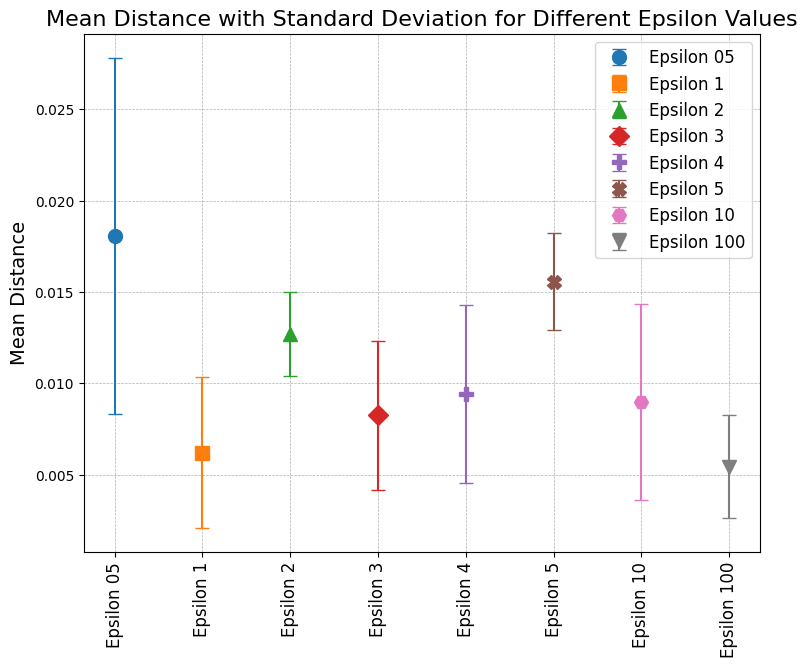

In [10]:
plot_error_bar(  # Extracting the means and standard errors
    labels=list(results_mean.keys()),
    results_mean=results_mean,
    results_std=results_std,
    y_label="Mean Distance",
    title="Mean Distance with Standard Deviation for Different Epsilon Values",
)

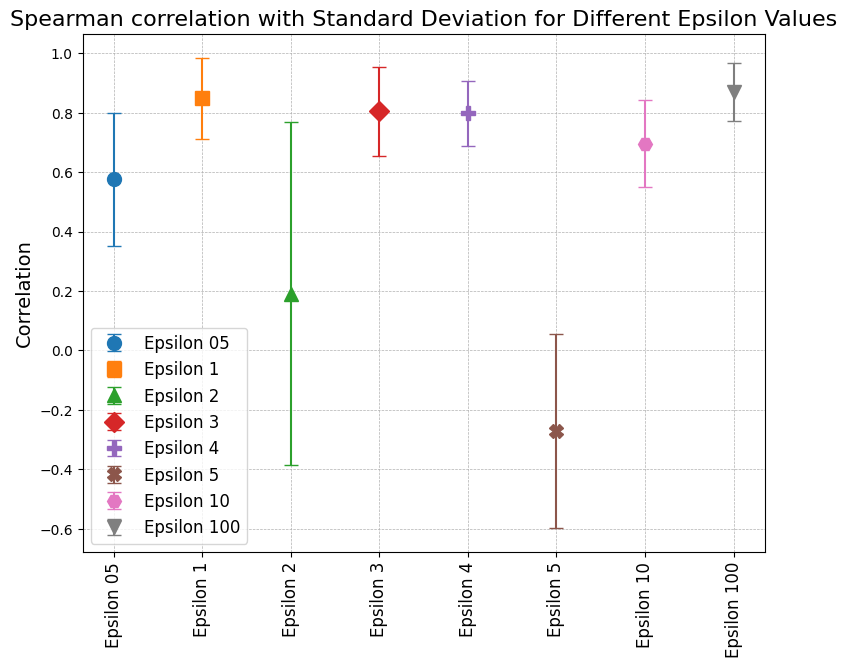

In [11]:
plot_error_bar(  # Extracting the means and standard errors
    labels=list(spearman_mean.keys()),
    results_mean=spearman_mean,
    results_std=spearman_std,
    y_label="Correlation",
    title="Spearman correlation with Standard Deviation for Different Epsilon Values",
)

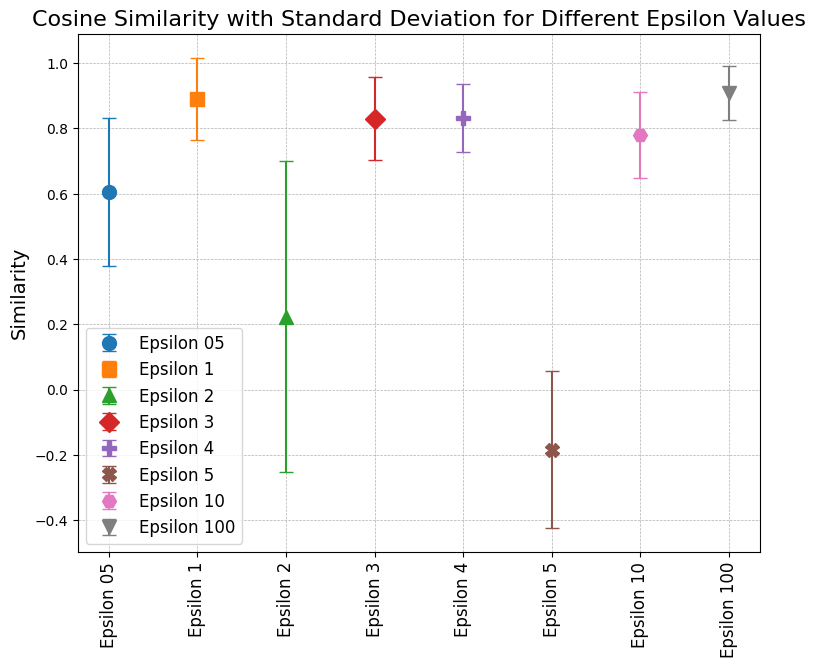

In [12]:
plot_error_bar(  # Extracting the means and standard errors
    labels=list(cosine_mean.keys()),
    results_mean=cosine_mean,
    results_std=cosine_std,
    y_label="Similarity",
    title="Cosine Similarity with Standard Deviation for Different Epsilon Values",
)

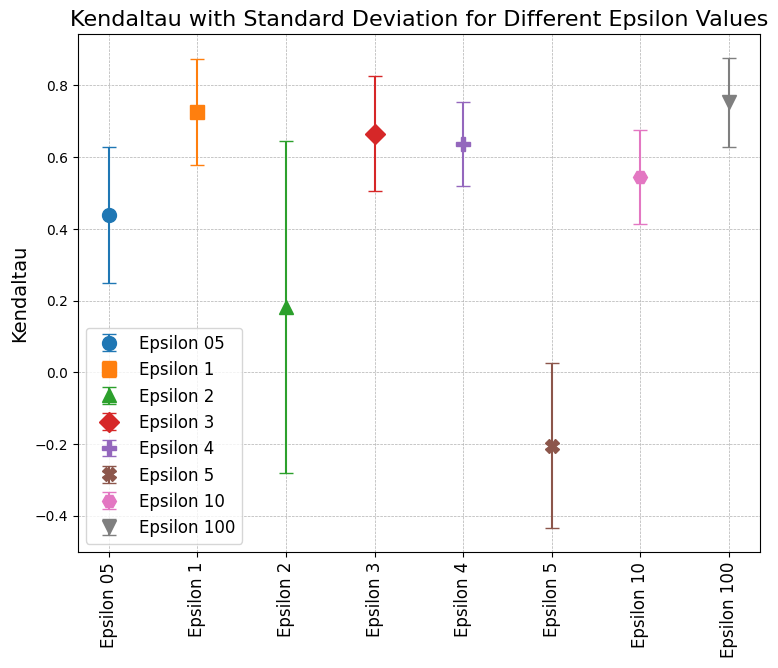

In [13]:
plot_error_bar(  # Extracting the means and standard errors
    labels=list(kendaltau_mean.keys()),
    results_mean=kendaltau_mean,
    results_std=kendaltau_std,
    y_label="Kendaltau",
    title="Kendaltau with Standard Deviation for Different Epsilon Values",
)

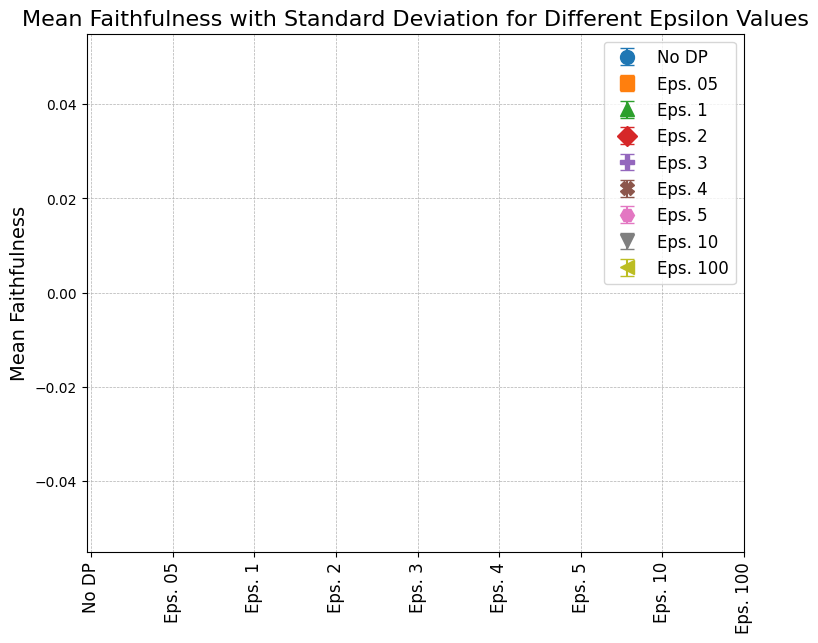

In [14]:
plot_faithfulness_std_dev(
    faithfulness_no_dp,
    faithfulness_eps_05,
    faithfulness_eps_1,
    faithfulness_eps_2,
    faithfulness_eps_3,
    faithfulness_eps_4,
    faithfulness_eps_5,
    faithfulness_eps_10,
    faithfulness_eps_100,
)

In [15]:
!pip install seaborn
import seaborn as sns


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip


/tmp/ipykernel_2632343/3854626625.py:28: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(faits, fill=True, ls="--", label=names)
/tmp/ipykernel_2632343/3854626625.py:29: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/tmp/ipykernel_2632343/3854626625.py:28: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(faits, fill=True, ls="--", label=names)
/tmp/ipykernel_2632343/3854626625.py:29: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/tmp/ipykernel_2632343/3854626625.py:28: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=F

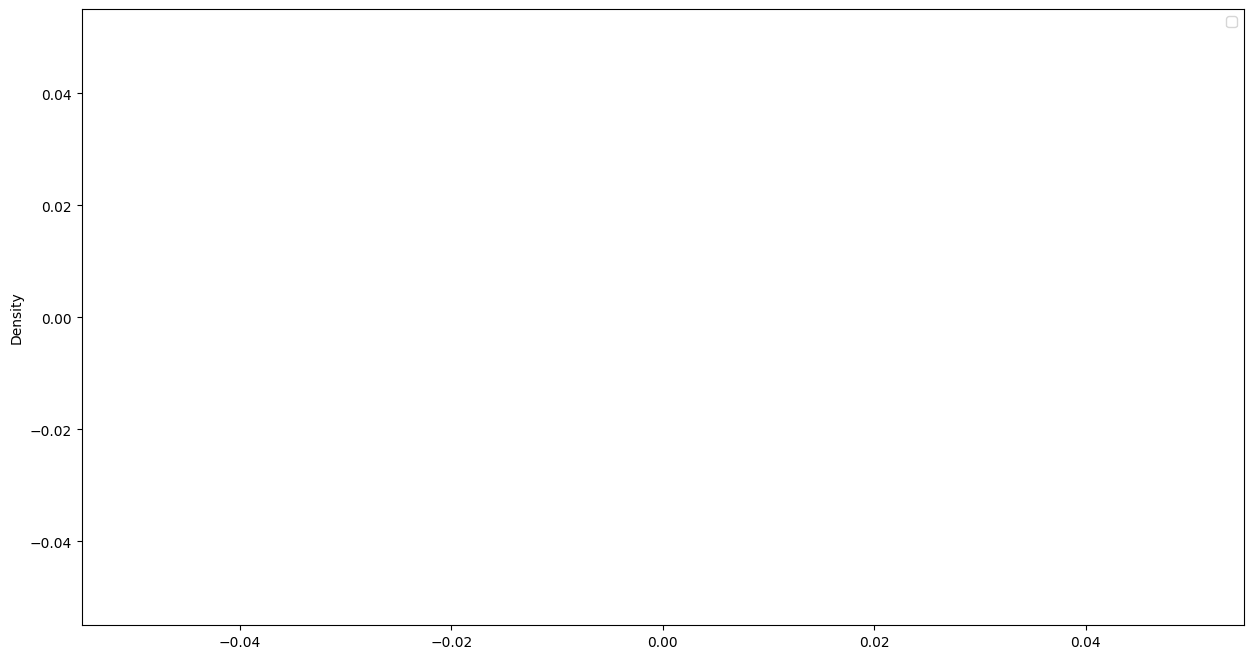

In [16]:
# import sns
fait = [
    faithfulness_no_dp,
    faithfulness_eps_05,
    faithfulness_eps_1,
    faithfulness_eps_2,
    faithfulness_eps_3,
    faithfulness_eps_4,
    faithfulness_eps_5,
    faithfulness_eps_10,
    faithfulness_eps_100,
]
names_f = [
    "faithfulness_no_dp",
    "faithfulness_eps_05",
    "faithfulness_eps_1",
    "faithfulness_eps_2" "faithfulness_eps_3",
    "faithfulness_eps_4",
    "faithfulness_eps_5",
    "faithfulness_eps_10",
    "faithfulness_eps_100",
]
# now we draw the kde with sns for the faithfulness

plt.figure(figsize=(15, 8))

for faits, names in zip(fait, names_f):
    sns.kdeplot(faits, fill=True, ls="--", label=names)
    plt.legend()